# Amanda's Notes

In [1]:
pip install shared_utils

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)

import branca
import folium
from shared_utils import gtfs_utils_v2
from segment_speed_utils import (helpers, 
                                 gtfs_schedule_wrangling, 
                                )

import pandas as pd
import geopandas as gpd 

import datetime as dt
import time
import fsspec
import gcsfs
from calitp_data_analysis import get_fs
fs = get_fs()
import tempfile

**`_shared_utils/shared_utils/rt_dates` contains a list of all of the dates we use to aggregate the GTFS data into data that backs the GTFS Digest/Speed Maps/etc. Perhaps we want to use data from one of those dates to keep everything cohesive, but I am not sure if this is important.**

In [3]:
#Setting analysis date
analysis_dt = dt.date(2025,6,2)

In [4]:
# #Function to fetch feeds, trips, stoptimes and stops_geo data from warehouse v2
# def get_feeds_trips_stops_data(selected_date):
    
#     trip_cols = ["name", "gtfs_dataset_key", "feed_key", "trip_id", "route_id", "route_type", "route_key", 
#                  "num_stop_times", "direction_id", "trip_first_departure_sec", "trip_first_departure_ts", 
#                  "trip_last_arrival_sec", "trip_start_timezone", "trip_instance_key", "service_hours", "trip_first_departure_datetime_pacific"]
#     stoptimes_cols = ["key", "_gtfs_key", "feed_key", "trip_id", "stop_id", "stop_sequence", "arrival_time", "departure_time",
#        "arrival_time_interval", "departure_time_interval", "arrival_hour", "departure_hour"]
#     stop_cols = ["feed_key", "stop_id", "geometry", "stop_name", "stop_code", "location_type", "stop_desc"]
    
#     feed_data = gtfs_utils_v2.schedule_daily_feed_to_gtfs_dataset_name(selected_date=selected_date)
    
    
#     feed_key_list = feed_data['feed_key'].tolist()
    
#     trips_data_list = []
#     stoptimes_data_list = []
#     stop_locations_gdf = gpd.GeoDataFrame()
#     for feed_key in feed_key_list:
#         try:
#             trips = gtfs_utils_v2.get_trips(selected_date=selected_date, operator_feeds=[feed_key])[trip_cols]
#             trips_data_list.append(trips)

#             stoptimes = gtfs_utils_v2.get_stop_times(selected_date=selected_date, operator_feeds=[feed_key], 
#                                                     trip_df=trips, get_df=True)[stoptimes_cols]
#             stoptimes_data_list.append(stoptimes)

#             stops_gdf = gtfs_utils_v2.get_stops(selected_date=selected_date, operator_feeds=[feed_key])[stop_cols]
#             stop_locations_gdf = pd.concat([stop_locations_gdf, stops_gdf], ignore_index=True)
#         except:
#             print('Skipping a row')
    
#     trips_data = pd.concat(trips_data_list, ignore_index=True)
#     stoptimes_data = pd.concat(stoptimes_data_list, ignore_index=True)
    
#     return feed_data, trips_data, stoptimes_data, stop_locations_gdf

In [5]:
# feed_data, trips_data, stoptimes_data, stop_locations_gdf = get_feeds_trips_stops_data(analysis_dt)

In [6]:
GCS_FILE_PATH  = 'gs://calitp-analytics-data/data-analyses/ahsc_grant'

Exporting data to GCS for reuse, minimizing repeated warehouse queries.

In [7]:
# trips_data.to_parquet(f"{GCS_FILE_PATH}/trips_06_02_2025.parquet")
# stoptimes_data.to_csv(f"{GCS_FILE_PATH}/stoptimes_06_02_2025.csv")
# feed_data.to_parquet(f"{GCS_FILE_PATH}/feed_06_02_2025.parquet")
# with fsspec.open(f"{GCS_FILE_PATH}/stop_locations_06_02_2025.parquet", 'wb') as f:
#     stop_locations_gdf.to_parquet(f)

**There are so many ways to answer the same question, but I am linking this [previous code](https://github.com/cal-itp/data-analyses/blob/main/gtfs_funnel/stop_arrivals_in_roads.py#L42-L88) here for our reference.**

Reading stoptimes, trips, feed and stop locations data 

In [8]:
stoptimes_data = pd.read_csv(f"{GCS_FILE_PATH}/stoptimes_06_02_2025.csv")

/tmp/ipykernel_1946/658927763.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  stoptimes_data = pd.read_csv(f"{GCS_FILE_PATH}/stoptimes_06_02_2025.csv")


In [9]:
trips_data = pd.read_parquet(f"{GCS_FILE_PATH}/trips_06_02_2025.parquet")

In [10]:
feed_data = pd.read_parquet(f"{GCS_FILE_PATH}/feed_06_02_2025.parquet")

**I wonder if you would save some memory if you did a spatial join right after loading in `stop_locations_gdf` to retain only California based stops, instead of doing a spatial join at the end?**

In [11]:
with fs.open(f"{GCS_FILE_PATH}/stop_locations_06_02_2025.parquet", 'rb') as f:
    stop_locations_gdf = gpd.read_parquet(f)

In [12]:
len(stop_locations_gdf)

85773

In [13]:
stoptimes_data.info() #Getting stoptimes data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565708 entries, 0 to 3565707
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   key                      object 
 2   _gtfs_key                object 
 3   feed_key                 object 
 4   trip_id                  object 
 5   stop_id                  object 
 6   stop_sequence            int64  
 7   arrival_time             object 
 8   departure_time           object 
 9   arrival_time_interval    object 
 10  departure_time_interval  object 
 11  arrival_hour             float64
 12  departure_hour           float64
dtypes: float64(2), int64(2), object(9)
memory usage: 353.7+ MB


In [14]:
trips_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162083 entries, 0 to 162082
Data columns (total 16 columns):
 #   Column                                 Non-Null Count   Dtype              
---  ------                                 --------------   -----              
 0   name                                   162083 non-null  object             
 1   gtfs_dataset_key                       162083 non-null  object             
 2   feed_key                               162083 non-null  object             
 3   trip_id                                162083 non-null  object             
 4   route_id                               162083 non-null  object             
 5   route_type                             162083 non-null  object             
 6   route_key                              162083 non-null  object             
 7   num_stop_times                         162083 non-null  int64              
 8   direction_id                           94257 non-null   float64           

In [15]:
trips_data_cleaned = trips_data.drop_duplicates() # Dropping duplicates

In [16]:
trips_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162072 entries, 0 to 162082
Data columns (total 16 columns):
 #   Column                                 Non-Null Count   Dtype              
---  ------                                 --------------   -----              
 0   name                                   162072 non-null  object             
 1   gtfs_dataset_key                       162072 non-null  object             
 2   feed_key                               162072 non-null  object             
 3   trip_id                                162072 non-null  object             
 4   route_id                               162072 non-null  object             
 5   route_type                             162072 non-null  object             
 6   route_key                              162072 non-null  object             
 7   num_stop_times                         162072 non-null  int64              
 8   direction_id                           94246 non-null   float64           

In [17]:
#Merging stop data with trip data on trip id and feed key.
stop_trip_merged = pd.merge(stoptimes_data,
                            trips_data_cleaned,
                            on = ['trip_id', 'feed_key'],
                            how = 'left')

In [29]:
len(stoptimes_data)

3565708

In [30]:
len(trips_data_cleaned)

162072

In [18]:
# Adding peak/off-peak labels to trip instances based on scheduled time buckets for the given analysis date
sched_time_of_day = gtfs_schedule_wrangling.get_trip_time_buckets(
    analysis_dt
).pipe(
    gtfs_schedule_wrangling.add_peak_offpeak_column
)[["trip_instance_key", "peak_offpeak"]]

In [19]:
#Merging scheduled time of the data 
stop_trip_merged = pd.merge(
    stop_trip_merged,
    sched_time_of_day,
    on='trip_instance_key',
    how='left'
)

In [28]:
len(stop_trip_merged)

4794045

In [20]:
# Counting unique trips per stop and renaming column to 'num_trips'
num_trips_per_stop = stop_trip_merged.groupby('stop_id')['trip_id'].nunique().reset_index().rename(columns={'trip_id':'num_trips'})

In [21]:
num_trips_per_stop.shape

(67034, 2)

In [22]:
# Counting unique routes per stop and renaming column to 'num_routes'
num_routes_per_stop = stop_trip_merged.groupby('stop_id')['route_id'].nunique().reset_index().rename(columns={'route_id':'num_routes'})

In [23]:
num_routes_per_stop.shape

(67034, 2)

In [24]:
# Filtering stop-trip data to include only peak period trips
peak_stop_times = stop_trip_merged[stop_trip_merged['peak_offpeak'] == 'peak'].copy()

In [25]:
peak_stop_times.head(2)

,Unnamed: 0,key,_gtfs_key,feed_key,trip_id,stop_id,stop_sequence,arrival_time,departure_time,arrival_time_interval,...,num_stop_times,direction_id,trip_first_departure_sec,trip_first_departure_ts,trip_last_arrival_sec,trip_start_timezone,trip_instance_key,service_hours,trip_first_departure_datetime_pacific,peak_offpeak
0,0,5161caf10ab1cd54000d20147a5bb66a,321223a0cbd2c6d8c8f9700229ed2807,ace4e22d6f2c299c36eba89ccb650b1b,28026b4c-26f6-441e-a2b5-8f404a9ee35f:3,8e75858c-2558-497a-8fd0-cb98973bc4bb,8,08:32:00,08:32:00,"relativedelta(hours=+8, minutes=+32)",...,18.0,NaN,30000.0,2025-06-02 15:20:00+00:00,31680.0,America/Los_Angeles,9c9641ab60e3228c6a686a1fd90aa53b,0.466667,2025-06-02 08:20:00,peak
1,1,0e82dbe3815ccec910ed8628f17ebb3b,7b7347565146ffd959836e2ed0e53499,ace4e22d6f2c299c36eba89ccb650b1b,eb73451d-48bc-4091-ae36-e4713073e5b3:3,ba6aaa37-5e60-44ad-8b2e-ca7f8baca0f5,9,08:32:00,08:32:00,"relativedelta(hours=+8, minutes=+32)",...,18.0,NaN,30000.0,2025-06-02 15:20:00+00:00,31860.0,America/Los_Angeles,8015976ac06bf7fe511b2bc4a98b7333,0.516667,2025-06-02 08:20:00,peak


In [26]:
peak_stop_times.shape

(1816847, 28)

**When I was working on the Transit Bunching, I found the `arrival_seconds` to be rather funky. I wonder if grabbing the hour from the `arrival_time` or `departure_time` column might be easier.**

In [ ]:
# Converting 'arrival_time' to total seconds since midnight
peak_stop_times['arrival_seconds'] = pd.to_timedelta(peak_stop_times['arrival_time']).dt.total_seconds()

In [ ]:
# Extracting hour from arrival_seconds
peak_stop_times = peak_stop_times.dropna(subset=['arrival_seconds']).copy()
peak_stop_times['arrival_hour'] = (peak_stop_times['arrival_seconds'] // 3600).astype(int)

In [ ]:
peak_stop_times.arrival_hour.describe()

In [ ]:
peak_stop_times.arrival_time.value_counts()

**If we want to follow the peak/offpeak cutoffs [here](https://github.com/cal-itp/data-analyses/blob/10fb6a88d3054da7162f1486a00aedc5122ecdd9/traffic_ops/utils.py#L10), then maybe you can change the cutoff to be 9 instead of 12.**

In [ ]:
# Defining AM peak as arrivals before noon (< 12)
peak_stop_times['peak_period'] = peak_stop_times['arrival_hour'].apply(
    lambda h: 'AM Peak' if h < 12 else 'PM Peak'
)

am_peak_times = peak_stop_times[peak_stop_times['peak_period'] == 'AM Peak'].copy()

In [ ]:
# Selecting relevant columns for AM peak times analysis
am_peak_times_trimmed = am_peak_times[['stop_id', 'feed_key', 'route_id', 'direction_id', 'arrival_seconds']].copy()

# Sorting AM peak times by stop, feed, route, direction, and arrival time
am_peak_times_sorted = am_peak_times_trimmed.sort_values(
    ['stop_id', 'feed_key', 'route_id', 'direction_id', 'arrival_seconds']
)

**If you use `route_dir = merge_data.concatenate_schedule_by_route_direction([analysis_date])[ route_dir_columns]`, this dataset already contains the column `frequency`, which you can divide with 60 to get the headway.** <p>
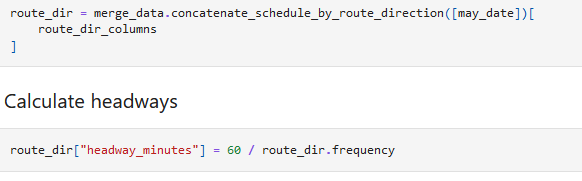

In [ ]:
# time difference between consecutive arrivals at same stop/route/direction)
am_peak_times_sorted['headway_seconds'] = (
    am_peak_times_sorted
    .groupby(['stop_id', 'feed_key', 'route_id', 'direction_id'])['arrival_seconds']
    .diff()
)

# Converting to minutes
am_peak_times_sorted['headway_minutes'] = am_peak_times_sorted['headway_seconds'] / 60

# Droping NaN headways (first arrival in each group will have NaN headway)
am_peak_times_sorted = am_peak_times_sorted.dropna(subset=['headway_seconds'])

In [ ]:
# Calculating average AM peak headway (minutes) for each stop
headways_per_stop = (
    am_peak_times_sorted
    .groupby('stop_id')['headway_minutes']
    .mean()  
    .reset_index()
    .rename(columns={'headway_minutes': 'am_peak_headway_minutes'})
)

In [ ]:
headways_per_stop['am_peak_headway_minutes'].max()

In [ ]:
# Removing duplicate stops based on stop ID and stop name
stop_locations_gdf_filtered = stop_locations_gdf.drop_duplicates(subset=['stop_id', 'stop_name'])

In [ ]:
len(stop_locations_gdf_filtered), len(stop_locations_gdf)

In [ ]:
# Loading California county boundaries GeoJSON data from ArcGIS REST service
CA_URL = "https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/arcgis/rest/services/California_County_Boundaries/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
CA_county = gpd.read_file(CA_URL)

In [ ]:
CA_county = CA_county.to_crs(stop_locations_gdf_filtered.crs)

In [ ]:
# Spatially joining stop locations with California county boundaries to keep stops within CA
stop_locations_gdf_ca = gpd.sjoin(
    stop_locations_gdf_filtered,  
    CA_county,                    
    how='inner',
    predicate='intersects'
)

In [ ]:
stop_locations_gdf_ca.shape

In [ ]:
# Merging all parts together
stop_summary = (
    stop_locations_gdf_ca[['stop_id', 'stop_name', 'COUNTY_NAME', 'stop_code', 'location_type', 'stop_desc', 'geometry']]
    .merge(num_trips_per_stop, on='stop_id', how='left')
    .merge(num_routes_per_stop, on='stop_id', how='left')
    .merge(headways_per_stop[['stop_id', 'am_peak_headway_minutes']], on='stop_id', how='left')
)

In [ ]:
columns_to_keep = ['stop_id', 'stop_name', 'COUNTY_NAME', 'stop_code', 'location_type', 'geometry', 'num_trips', 'num_routes',
       'am_peak_headway_minutes' ]
stop_summary_final = stop_summary[columns_to_keep]

In [ ]:
stop_summary_final.sample(5)

In [ ]:
stop_summary_final.am_peak_headway_minutes.describe()

In [ ]:
# Saving geojson file
#with tempfile.NamedTemporaryFile(suffix=".geojson") as tmp:
#    stop_summary_final.to_file(tmp.name, driver="GeoJSON")

#
#    with fsspec.open(f"{GCS_FILE_PATH}/stop_summary.geojson", 'w') as f_out:
  #      with open(tmp.name, 'r') as f_in:
    #        f_out.write(f_in.read())